In [1]:
import sys
sys.path.append('..')
import ugent
from pyslise2d import Pyslise2D

V = lambda x, y: (1+x*x)*(1+y*y)

p = Pyslise2D(V, -5.5,5.5, -5.5,5.5, tolerance=1e-8)

In [37]:
eigenvalues = p.eigenvaluesByIndex(0, 10)

In [17]:
from pqdm.processes import pqdm
import numpy as np

def get_errors(E):
    return p.__matchingErrors(E)

Es = np.linspace(-1, 11, 10000)
errors = pqdm(Es, get_errors, n_jobs=8)

QUEUEING TASKS | :   0%|          | 0/10000 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/10000 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/10000 [00:00<?, ?it/s]

In [210]:
import matplotlib.pyplot as plt

def guess_lines(Es, errors):
    lines = [[(Es[0], e, de)] for e, de in errors[0]]
    new_lines = set(range(len(lines)))
    
    for i in range(1, len(errors)):
        h = Es[i] - Es[i-1]
        error = set(errors[i])
        
        old_lines = new_lines
        new_lines = set()
        
        while error:   
            def key(ede):
                e, de = ede
                predicted = e - h*de
                def line_key(line_index):
                    return abs(predicted - lines[line_index][-1][1])
                best_line = min(old_lines, key=line_key) 
                return line_key(best_line), best_line

            err = min(error, key=key)
            error.remove(err)
            prediction_error, line_index = key(err)
            v = (Es[i], *err)
            if prediction_error < 1:
                lines[line_index].append(v)
                new_lines.add(line_index)
                old_lines.remove(line_index)
            else:
                new_lines.add(len(lines))
                lines.append([v])
    return lines

lines = guess_lines(Es, errors)

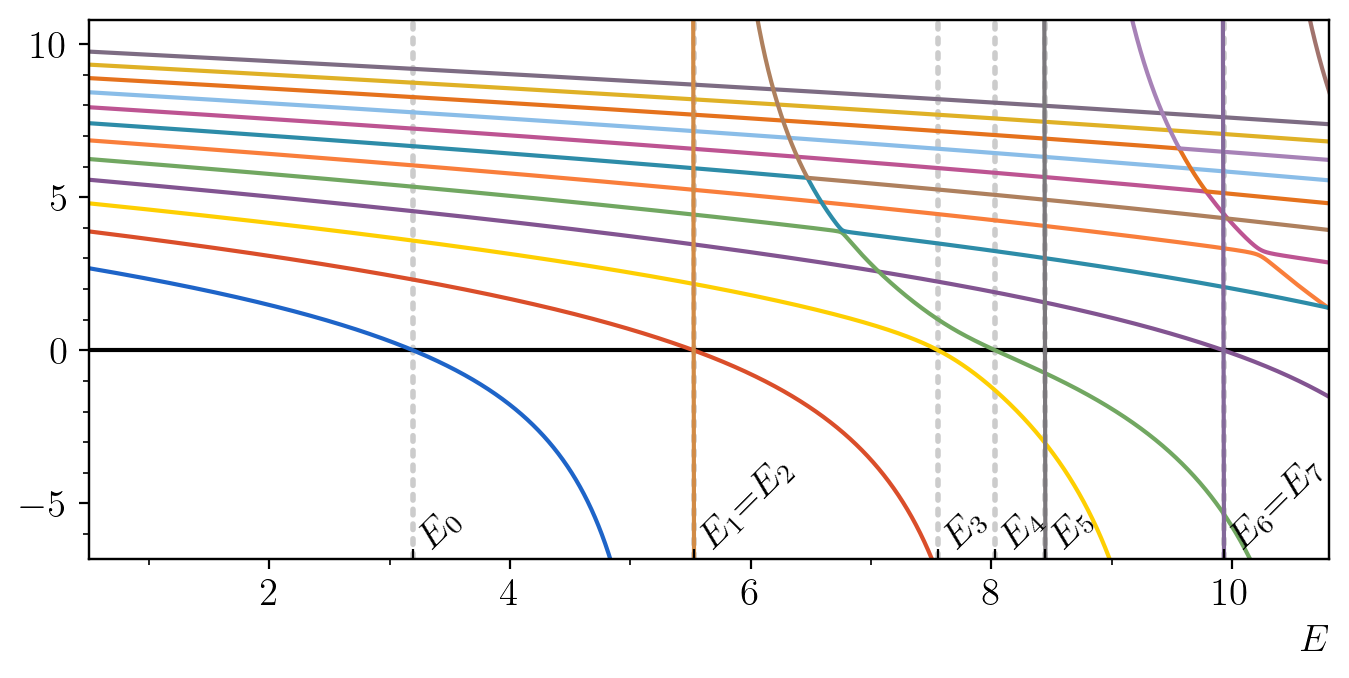

In [219]:
from matplotlib.ticker import FixedLocator, FormatStrFormatter, ScalarFormatter

fig, ax = plt.subplots(figsize=(8, 3.5), dpi=200)

ax.xaxis.set_minor_locator(FixedLocator(range(-1, 20, 1)))
ax.yaxis.set_minor_locator(FixedLocator(range(-20, 20, 1)))

ylow, yhigh = -6.8, 10.8
xlow, xhigh = 0.5, 10.8


ax_eigs = ax.twiny()
ax_eigs.xaxis.tick_bottom()
ax_eigs.set_xticks(
    [e for i, e, m in  eigenvalues],
    labels=['$' + '\\text{$=$}'.join(f'E_{{{j}}}' for j in range(i, i+m)) + '$' for i, e, m in eigenvalues],
    rotation=45,
    ha='left',
    va='bottom'
)
ax_eigs.tick_params(axis="x",direction="in", pad=-1)
ax_eigs.set_xlim(xlow, xhigh)

for i, e, m in  eigenvalues:
    if xlow < e < xhigh:
        ax.axvline(e, lw=2, ls=':', dash_capstyle="round", zorder=-1, c=ugent.zwart, alpha=0.2)


for c, line in zip(ugent.palet, lines):
    ax.plot(*list(zip(*line))[:2], color=c)
ax.set_ylim(ylow, yhigh)
ax.set_xlim(xlow, xhigh)
ax.axhline(0, color=ugent.zwart, zorder=-2)
ax.set_xlabel('$E$', loc='right')

plt.savefig('mismatch_rainbow.pdf', bbox_inches="tight")

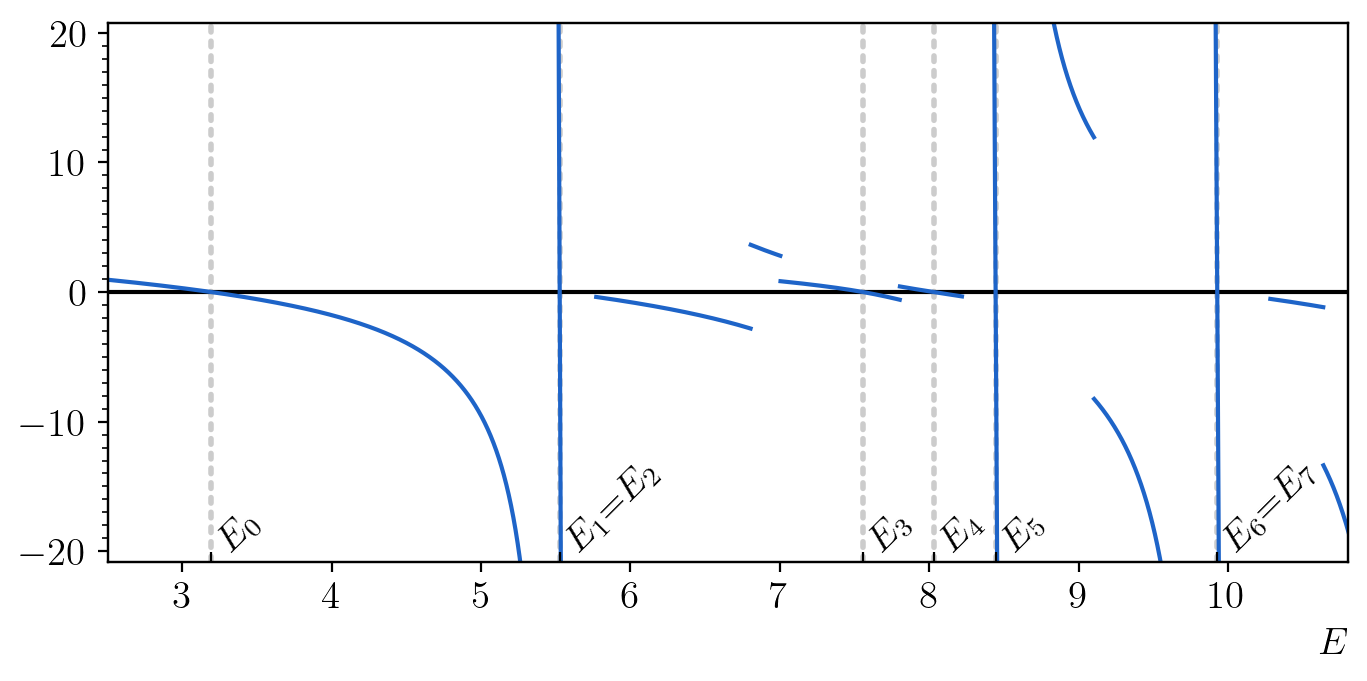

In [220]:
from matplotlib.ticker import FixedLocator, FormatStrFormatter, ScalarFormatter

fig, ax = plt.subplots(figsize=(8, 3.5), dpi=200)

ax.xaxis.set_minor_locator(FixedLocator(range(-1, 20, 1)))
ax.yaxis.set_minor_locator(FixedLocator(range(-20, 20, 1)))

ylow, yhigh = -20.8, 20.8
xlow, xhigh = 2.5, 10.8


ax_eigs = ax.twiny()
ax_eigs.xaxis.tick_bottom()
ax_eigs.set_xticks(
    [e for i, e, m in  eigenvalues],
    labels=['$' + '\\text{$=$}'.join(f'E_{{{j}}}' for j in range(i, i+m)) + '$' for i, e, m in eigenvalues],
    rotation=45,
    ha='left',
    va='bottom'
)
ax_eigs.tick_params(axis="x",direction="in", pad=-1)
ax_eigs.set_xlim(xlow, xhigh)

for i, e, m in  eigenvalues:
    if xlow < e < xhigh:
        ax.axvline(e, lw=2, ls=':', dash_capstyle="round", zorder=-1, c=ugent.zwart, alpha=0.2)


lines_dicts = [{E: (e, de) for E, e, de in line} for line in lines]
newton_lines = []
prev_line = -1
for E in Es:
    def key(i):
        d = lines_dicts[i]
        if E not in d:
            return 1e100
        e, de = d[E]
        return abs(e/de)
    
    i = min(range(len(lines_dicts)), key=key)
    if i != prev_line:
        newton_lines.append([])
    newton_lines[-1].append((E, lines_dicts[i][E][0]))
    prev_line = i
    
    
for line in newton_lines:
    ees, data = zip(*line)
    ax.plot(ees, data, color=ugent.blauw)

ax.set_ylim(ylow, yhigh)
ax.set_xlim(xlow, xhigh)
ax.axhline(0, color=ugent.zwart, zorder=-2)
ax.set_xlabel('$E$', loc='right')

plt.savefig('mismatch_newton.pdf', bbox_inches="tight")

QUEUEING TASKS | :   0%|          | 0/10000 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/10000 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/10000 [00:00<?, ?it/s]

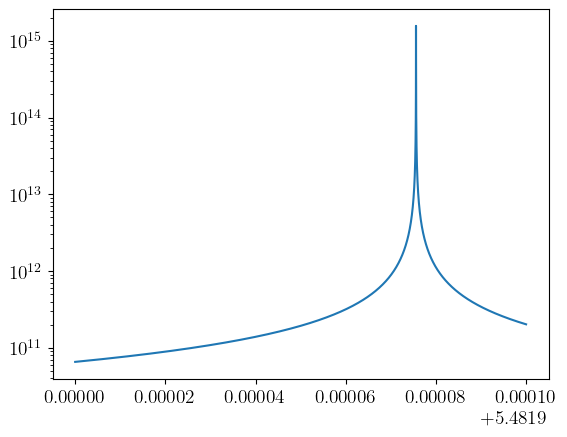

In [242]:
from pqdm.processes import pqdm
import numpy as np

def get_det_error(E):
    return np.product(np.array(p.__matchingErrors(E))[:,0])

Es = np.linspace(5.4819, 5.482, 10000)
det_errors = np.array(pqdm(Es, get_det_error, n_jobs=12))

plt.semilogy(Es, np.abs(det_errors))
plt.show()